# analysis fastReach 

# 1. general prep


In [3]:

# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
# %load_ext rpy2.ipython # currently not needed
import glob

from wordcloud import WordCloud, STOPWORDS
#from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pymer4 as pymer4

#for anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM


In [4]:
# set repository
p= "C://Users/terfu/Desktop/2021-fastReach/data/study/" #repository for output

# 2. temporal binding



## prep
### load data

In [5]:
# load data
behavior_raw= pd.read_csv( p + 'PI_results_design.csv')

# set data types
behavior_raw[['ed','rt']] = behavior_raw[['ed','rt']].apply(pd.to_numeric, axis=1)

behavior_raw['rd'] = behavior_raw['rd'].astype("string")  # needs to be string before category for R conversion

behavior_raw[['rd','condition']] = behavior_raw[['rd','condition']].astype("category")


### check raw data (rection times and estimated times)


(0.0, 5.0)

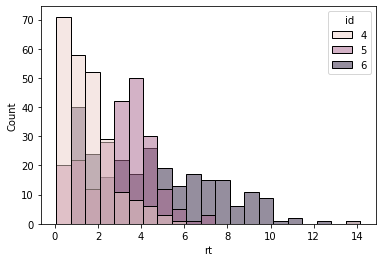

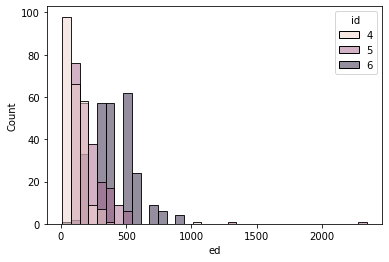

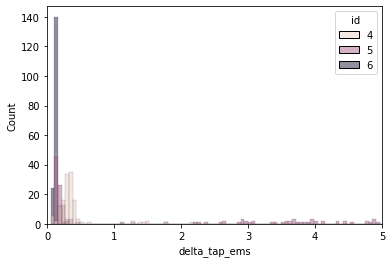

In [6]:
fig, ax = plt.subplots()
hist = sns.histplot(behavior_raw, x = 'rt',ax =ax, hue = 'id')
#ax.set_xlim(0,5) # remove outliers for visualization

fig, ax = plt.subplots()
hist = sns.histplot(behavior_raw, x = 'ed',ax =ax, hue = 'id')


fig, ax = plt.subplots()
hist = sns.histplot(behavior_raw, x = 'delta_tap_ems',ax =ax, hue = 'id')
ax.set_xlim(0,5) # remove outliers for visualization

### clean data

In [7]:
# removes outliers trials that have outliers either in rt or ed
#@Lukas: do we want to remove only extreme or all outliers?

cols = ['rt', 'ed','delta_tap_ems'] # relevant cols

# calculate quantiles and IQR
Q1 = behavior_raw[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = behavior_raw[cols].quantile(0.75)
IQR = Q3 - Q1

# return a boolean array of the rows with (any) non-outlier column values
condition = ~((behavior_raw[cols] < (Q1 - 3 * IQR)) | (behavior_raw[cols] > (Q3 + 3 * IQR))).any(axis=1)

# filter our dataframe based on condition
behavior = behavior_raw[condition]
behavior_del = behavior_raw[-condition]

In [8]:
# check outlier removel

#count deleted trials
print('Deleted trials:',len(behavior_del))

#per pID
print('Deleted trials per pID')
print(behavior_del['id'].value_counts())

print('mean')
print(behavior_del['id'].value_counts().mean())
print('sd')
print(behavior_del['id'].value_counts().std())

#per condition
print('Deleted trials per condition')
print(behavior_del['condition'].value_counts())
print('mean')
print(behavior_del['condition'].value_counts().mean())
print('sd')
print(behavior_del['condition'].value_counts().std())


Deleted trials: 72
Deleted trials per pID
5    61
4     9
6     2
Name: id, dtype: int64
mean
24.0
sd
32.2335229225724
Deleted trials per condition
ems_bci       67
ems_random     3
baseline       2
Name: condition, dtype: int64
mean
24.0
sd
37.242448899072144


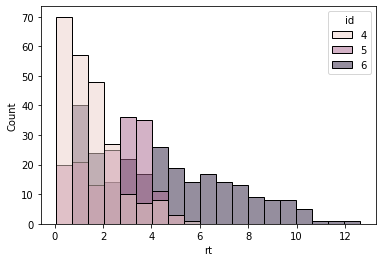

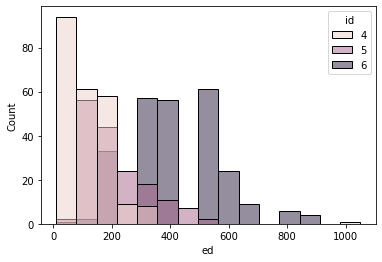

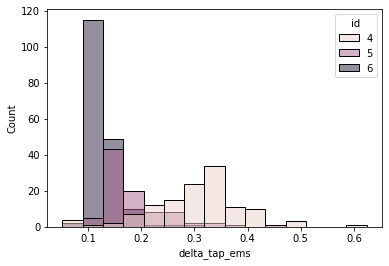

In [9]:
#check new data

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'rt',ax =ax, hue = 'id')
#ax.set_xlim(0,5) # remove outliers for visualization

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'ed',ax =ax, hue = 'id')

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'delta_tap_ems',ax =ax, hue = 'id')


## plot
### prep plot

In [11]:
# with stimulation condition + time condition+ rd as y

behavior[['rd']] = behavior[['rd']].apply(pd.to_numeric, axis=1)
behavior["diff"]= behavior["ed"]-behavior["rd"]
behavior[['rd']] = behavior[['rd']].astype("category")


####tbd - change diff to rd-ed to get positive value for understimation
behavior["diff"] = behavior["diff"]*-1

behavior_means = behavior.groupby(['id','condition','rd'],as_index=False)['diff'].mean()

palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['baseline','ems_random','ems_bci'] 
ylabel = 'ed-rd'
xlabel = 'condition'
title = 'condition + rd'
data = behavior
data_means = behavior_means
y = 'diff'
x = "condition"
hue = "id"
hue2 = 'rd'



C:\Users\terfu\AppData\Local\Temp\ipykernel_17584\2812942076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior[['rd']] = behavior[['rd']].apply(pd.to_numeric, axis=1)
C:\Users\terfu\AppData\Local\Temp\ipykernel_17584\2812942076.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["diff"]= behavior["ed"]-behavior["rd"]
C:\Users\terfu\AppData\Local\Temp\ipykernel_17584\2812942076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

### plot


@ Lukas: double check; does this make sense to you?

 I used diff (ed-rd) as the depent measure. This basically describes the underestimation of the duration between touch and tone. Larger negative values describe larger underestimation, i.e., interval was 200 ms (rd)  but was estimated 100ms (ed), the dependet measure would be -100 ms. A value of 0 depicts a matching estimate. 

We assume that high agency leads to increased underestimation (temporal binding), therewith the baseline should have the lowest vaule, passive the highest (around 0) and agency should be somewhere inbetween. 

Would it make sense to invert the graphic/diff (*-1) - because high in underestimation is connected to high agency = both graphics would go the same direction.


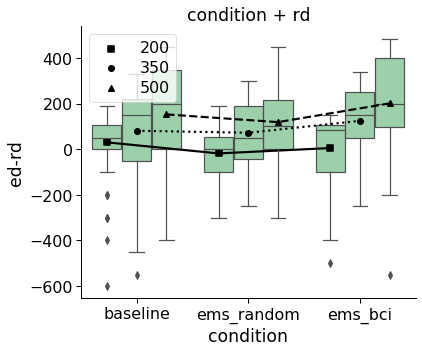

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [44]:
# runs plot but needs post processing in affinty desiger
cats_0 = data[data[x]==cats[0]]
cats_1 = data[data[x]==cats[1]]
cats_2 = data[data[x]==cats[2]]

pairs = [(cats[0], cats[1],cats[1])]


with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

        # show boxplots
    ax = sns.boxplot(data = data,x = x, y = y, hue = hue2, order= cats,  palette= [palette[3],palette[3],palette[3]], )
    for patch in ax.patches: # adapt alpha
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .6))

        # show line connecting menas
    ax = sns.pointplot(
        data = data,x = x, y = y, dodge=.8 - .8 / 3, 
        markers=['s','o','^'],linestyles = ['solid','dotted','dashed'],order= cats,hue = hue2, size = 6, ci =None,palette= ['black','black','black'], labels = True)
    

    handles, labels = ax.get_legend_handles_labels()  
    
    plt.legend(handles[3:6],labels[3:6],frameon=True,loc = 'upper left',labelspacing =0.3)
    
    # label_plot_for_subcats(ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    plt.show()
fig.savefig('results/'+title + '_' + ylabel + '_' + xlabel + '.svg', format='eps', transparent=True, bbox_inches='tight', dpi=300)
fig.savefig('results/'+title + '_' + ylabel + '_' + xlabel + '.png', format='eps', transparent=True, bbox_inches='tight', dpi=300)

## anaysis


### descriptive

In [12]:
# descreptive
print(behavior.groupby('condition')['diff'].agg(['mean','std']))

print(behavior.groupby('rd')['diff'].agg(['mean','std']))



                  mean         std
condition                         
baseline     88.693277  195.615599
ems_bci     110.904437  189.633527
ems_random   57.196581  160.975487
           mean         std
rd                         
200   10.274419  142.206622
350  100.100917  170.308283
500  168.674419  210.567005


### LMM

#### prep
- witched from rpy2 to pymer4, because it is less annoying with importing / exporting from python to R
- not sure if of this is still necessary, but since pymer4 is based on rpy2, this might be the case

In [13]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x0000021D25C33A00> [RTYPES.NILSXP]

In [14]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))
from pymer4.models import Lmer

R[write to console]: Installiere Pakete nach 'C:/Users/terfu/AppData/Local/R/win-library/4.2'
(da 'lib' nicht spezifiziert)

R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/lme4_1.1-34.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 4527240 bytes (4.3 MB)

R[write to console]: downloaded 4.3 MB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/lmerTest_3.1-3.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 529964 bytes (517 KB)

R[write to console]: downloaded 517 KB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/emmeans_1.8.8.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2177144 bytes (2.1 MB)

R[write to console]: downloaded 2.1 MB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/geepack_1.3.9.zip'

R[write to console]

Paket 'lme4' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'lmerTest' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'emmeans' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'geepack' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'sjPlot' erfolgreich ausgepackt und MD5 Summen abgeglichen




Exception ignored from cffi callback <function _consolewrite_ex at 0x0000021D262AA680>:
Traceback (most recent call last):
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 25: invalid continuation byte


In [41]:
# corr between diff and delta, to check wether delta could be a meaningful predictor
print(behavior['delta_tap_ems'])
behavior['diff'].corr(behavior['delta_tap_ems'])
#np.corrcoef(behavior['delta_tap_ems'],behavior['diff'])

# is high, maybe check AIC with and without delta

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
       ...  
715    0.108
716    0.108
717    0.104
718    0.120
719    0.128
Name: delta_tap_ems, Length: 648, dtype: float64


0.5145933885713561

#### built models

In [79]:
full_model2 = Lmer('diff ~ condition + rd + delta_tap_ems + (1|id)', data = behavior)
full_model2.fit(REML = False, summarize=False)

c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.



In [15]:
# full model

full_model = Lmer('diff ~ condition + rd + (1|id)', data = behavior)
display(full_model.fit(REML = False,factors={"condition": ["baseline", "ems_random", "ems_bci"], "rd": ["200", "350", "500"]}))
#full_model.plot_summary()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: diff~condition+rd+(1|id)

Family: gaussian	 Inference: parametric

Number of observations: 648	 Groups: {'id': 3.0}

Log-likelihood: -3985.104 	 AIC: 7984.209

Random effects:

                 Name        Var      Std
id        (Intercept)  16570.347  128.726
Residual               12527.832  111.928

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-2.987,-149.856,143.882,74.934,3.081,-0.040,0.971,
condition1,42.880,23.605,62.155,9.834,645.071,4.360,0.000,***
condition2,22.977,-2.035,47.988,12.761,645.083,1.801,0.072,.
rd1,86.938,65.849,108.027,10.760,645.003,8.080,0.000,***
rd2,159.938,138.779,181.097,10.796,645.003,14.815,0.000,***


In [80]:
pymer4.stats.lrt([full_model,full_model2])


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,diff~condition+rd+(1|id),7,7984.208653,8015.525887,-3985.104326,7970.208653,,,,
1,diff~condition+rd+delta_tap_ems+(1|id),7,4819.798010,4847.632466,-2402.899005,4805.798010,3164.410643,0.0,,


In [ ]:
# AIC and BIC are much lower with delta as a predictor - use delta as predicor?



#### define null models

In [16]:

# null model without stimulation condition 
null_model_stim = Lmer('diff ~ rd + (1|id)', data = behavior)
null_model_stim.fit(REML = False, summarize=False)

# null model without temp condition 
null_model_temp = Lmer('diff~ condition + (1|id)', data = behavior)
null_model_temp.fit(REML = False, summarize=False)


c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


#### liklyhood ratio tests



stimulation condition

In [17]:
pymer4.stats.lrt([null_model_stim,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,diff~rd+(1|id),5,7998.950087,8021.319541,-3994.475044,7988.950087,,,,
1,diff~condition+rd+(1|id),7,7984.208653,8015.525887,-3985.104326,7970.208653,18.741435,2.0,0.000085,***


temp condition

In [67]:
pymer4.stats.lrt([null_model_temp,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,ed~condition+(1|id),5,4735.781847,4755.739170,-2362.890924,4725.781847,,,,
1,ed~condition+rd+(1|id),7,4625.723347,4653.663599,-2305.861673,4611.723347,114.058501,2.0,0.0,***


#### post hoc test

TODO check wether this post_hoc test is correct


 @Lukas: Hier bin ich mir nicht sicher, ob man d as einfach so machen kann. Bzw. Also pairwise t-test mit dem full model. 
- in dem 2019 CPS Paper wird die Quelle verwendet für post-hoc test
 check - Wilcoxon, F.: Individual comparisons by ranking methods. Biom. Bull. 1(6), 80
(1945) 
- der code kommt von hier:  http://eshinjolly.com/pymer4/auto_examples/example_03_posthoc.html



In [18]:
# post hoc test stimulation condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="condition",p_adjust = "bonf")

print(comparisons)


P-values adjusted by bonf method for 3 comparisons
                Contrast  Estimate  2.5_ci  97.5_ci      SE       DF  T-stat  \
1     baseline - ems_bci   -42.880 -66.484  -19.275   9.834  645.071  -4.360   
2  baseline - ems_random   -22.977 -53.607    7.653  12.761  645.083  -1.801   
3   ems_bci - ems_random    19.903  -9.633   49.439  12.305  645.046   1.617   

   P-val  Sig  
1  0.000  ***  
2  0.217       
3  0.319       


In [21]:
# post hoc test interval
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="rd",p_adjust = "bonf")

print(comparisons)

P-values adjusted by bonf method for 3 comparisons
        Contrast  Estimate   2.5_ci  97.5_ci     SE     DF  T-stat  P-val  Sig
1  rd200 - rd350   -46.104  -68.578  -23.630  9.348  402.0  -4.932    0.0  ***
2  rd200 - rd500  -107.481 -129.913  -85.050  9.331  402.0 -11.519    0.0  ***
3  rd350 - rd500   -61.378  -83.851  -38.904  9.348  402.0  -6.566    0.0  ***


# 3. subjective data



In [19]:
questionaire= pd.read_excel(p + 'questionaire.xlsx') #read from repository 'remove test_data 

questionaire_long = questionaire.melt(id_vars= ['pID'],value_vars=['baseline','passive','agency'])

c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


### plot control

In [7]:
palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['item_baseline', 'item_passive', 'item_agency']
ylabel = 'level of control'
xlabel = 'condition'
title = 'fake'
data = questionaire_long
y = 'value'
x = 'variable'
hue = 'pID'

#cohend(data,x,y, cats)

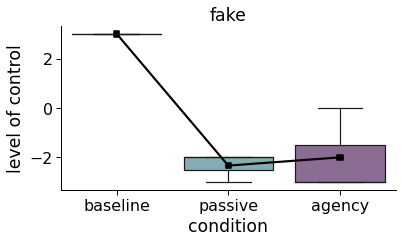

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
#test-- > to be integrated into plot_3_cats?

cats_0 = data[data[x]==cats[0]]
cats_1 = data[data[x]==cats[1]]
cats_2 = data[data[x]==cats[2]]

pairs = [(cats[0], cats[1],cats[1])]

with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(6,3))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True
         # show boxplots
        ax = sns.boxplot(data = data, x = x, y = y,  palette= palette[3:6])
        for patch in ax.patches: # adapt alpha
             r, g, b, a = patch.get_facecolor()
             patch.set_facecolor((r, g, b, .6))

        # show lines connecting pid means observations    
        #sns.lineplot(data = data, x = x, y = y, hue = hue,
        #            legend = False, linewidth = 0.5, linestyle = '-',ci =None,color = 'grey', alpha=0.8)
        

            
        # show line connecting means
        sns.pointplot(
            data = data,x = x, y = y,
            markers="s",linewidth = 1, size = 6, ci =None,color = 'black',legend = False)

        #sns.scatterplot(data = data,x = x, y = y, markers="^",color = 'black')


        
        # Label and show
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

      

        plt.show()
        fig.savefig('results/'+title + '_' + ylabel + '_' + xlabel + '.svg', format='eps', transparent=True, bbox_inches='tight', dpi=300)

#### ANOVA

In [20]:

print(AnovaRM(data=questionaire_long, depvar='value',
              subject='pID', within=['variable']).fit())





                Anova
         F Value Num DF Den DF Pr > F
-------------------------------------
variable 18.5385 2.0000 4.0000 0.0095



In [106]:
#POSTHOC TESTS
tukey = (endog=questionaire_long['value'],
                          groups=questionaire_long['variable'],
                          alpha=0.05)

print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  agency baseline   3.0833    0.0  1.8268  4.3398   True
  agency  passive  -1.4167 0.0243 -2.6732 -0.1602   True
baseline  passive     -4.5    0.0 -5.7565 -3.2435   True
--------------------------------------------------------


,mean,std
variable,,
agency,-0.583333,1.880925
baseline,2.500000,0.522233
passive,-2.000000,0.953463


# 3. Content Analysis
--> not yet adapted to new file format
- built to world clouds for each block
- define stopwords
- maybe check sentiment analysis -> pareid t-test?
-TODO: try word cloud german


In [164]:
interview_baseline = questionaire['text_baseline'].dropna().to_json(force_ascii = False)

interview_passive = questionaire['text_passive'].dropna().to_json(force_ascii = False)

interview_agency = questionaire['text_agency'].dropna().to_json(force_ascii = False)

stopwords = STOPWORDS # extend by domaine specific words if necessary

interview_baseline2 = questionaire['text_baseline'].dropna().to_string(force_ascii = False)

In [166]:
#todo check the difference to this code

interview_baseline2 = questionaire['text_baseline'].dropna().to_string()

In [167]:
print(interview_baseline2)

0    I chose to press the screen; I was using my fr...
1    Ich hatte kein Strom Gefühl; Hätte ich nicht g...
2    Es war  nicht manipuliert; ich habe ausgewählt...


In [168]:
wc_formate = WordCloud(background_color='black', max_words=500, width=3000,
                    height=1500, stopwords=stopwords, min_font_size=2,
                    contour_width=3, contour_color='white')

wc_formate.generate(interview_baseline2)
wc_formate.to_file(("results/wordcloud_baseline.png"))

wc_formate.generate(interview_passive)
wc_formate.to_file(("results/wordcloud_passive.png"))

wc_formate.generate(interview_passive)
wc_formate.to_file(("results/wordcloud_agency.png"))


# 4. Sentiment Analysis

In [159]:

analyzer=SentimentIntensityAnalyzer()  

print(analyzer.polarity_scores(interview_baseline))
print(analyzer.polarity_scores(interview_passive))
print(analyzer.polarity_scores(interview_agency))




{'neg': 0.166, 'neu': 0.764, 'pos': 0.07, 'compound': -0.6705}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.323, 'neu': 0.677, 'pos': 0.0, 'compound': -0.9815}
